In [39]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [40]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
from src.model import NN
from src.main import Trainer
np.random.seed(0)


#### Data pre-processing for MONK Datasets 

In [41]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

df = pd.read_csv("../ML_project/data/Monk_3/monks-3.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
#                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
df.set_index("index", inplace=True)
y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
for i in range(1, X.shape[1]):
    X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
        np.std(X.iloc[:, i])
X.head()

/tmp/ipykernel_1153/2770782428.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_2     -1.255411
data_3     -1.255411
data_4     -1.255411
data_5     -1.255411
data_7     -1.255411
              ...   
data_420    1.214913
data_422    1.214913
data_425    1.214913
data_430    1.214913
data_432    1.214913
Name: 2, Length: 122, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
/tmp/ipykernel_1153/2770782428.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_2     -0.936442
data_3     -0.936442
data_4     -0.936442
data_5     -0.936442
data_7     -0.936442
              ...   
data_420    1.067872
data_422    1.067872
data_425    1.067872
data_430    1.067872
data_432    1.067872
Name: 3, Length: 122, dtype: 

,1,2,3,4,5,6
index,,,,,,
data_2,1,-1.255411,-0.936442,-1.245633,-1.302980,0.967733
data_3,1,-1.255411,-0.936442,-1.245633,-0.419849,-1.033342
data_4,1,-1.255411,-0.936442,-1.245633,-0.419849,0.967733
data_5,1,-1.255411,-0.936442,-1.245633,0.463282,-1.033342
data_7,1,-1.255411,-0.936442,-1.245633,1.346413,-1.033342


In [42]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

test_data = pd.read_csv("../ML_project/data/Monk_3/monks-3.test",
names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
test_data.set_index("index", inplace=True)
# test_data.head()
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
for i in range(1, X_test.shape[1]):
    X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

/tmp/ipykernel_1153/2279363569.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.224745
data_2     -1.224745
data_3     -1.224745
data_4     -1.224745
data_5     -1.224745
              ...   
data_428    1.224745
data_429    1.224745
data_430    1.224745
data_431    1.224745
data_432    1.224745
Name: 2, Length: 432, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])
/tmp/ipykernel_1153/2279363569.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.0
data_2     -1.0
data_3     -1.0
data_4     -1.0
data_5     -1.0
           ... 
data_428    1.0
data_429    1.0
data_430    1.0
data_431    1.0
data_432    1.0
Name: 3, Length: 432, dtype: float64' has dty

In [43]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (97, 6)
Validation Features Shape: (25, 6)
Training Target Shape: (97,)
Validation Target Shape: (25,)


In [44]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

    def __call__(self, target, prediction):
        return self.backward(prediction, target)

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = None
        self.output = None
        
    def forward(self, y_pred, y_true):
        # Remove the shape condition - always calculate loss
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        self.dinputs = 2 * (dvalues - y_true) / samples
        return self.dinputs

In [45]:
# def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation):
#     # Initialize components
#     model = NN(
#         l1=l1,
#         l2=l2,
#         input_size=6,
#         hidden_sizes=[10],
#         output_size=2,
#         hidden_activations=[activation],
#         dropout_rates=[dropout_rate]
#     )
    
#     loss_activation = MSE()
#     optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

#     train_losses = []
#     train_accuracies = []
#     val_losses = []
#     val_accuracies = []

#     for epoch in range(n_epochs):
#         batch_losses = []
#         batch_accuracies = []
        
#         for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#             # Forward pass through model
#             model.forward(X_batch, training=True)
            
#             # Calculate loss through separate loss activation
#             loss = loss_activation.forward(model.output, y_batch)
#             # print(y_batch.shape)
#             # Calculate accuracy
#             predictions = np.argmax(loss_activation.output, axis=1)
#             accuracy = np.mean(predictions == y_batch)
            
#             # Backward pass
#             loss_activation.backward(loss_activation.output, y_batch)
#             dvalues = loss_activation.dinputs
            
#             # Propagate gradients through model layers in reverse
#             for layer in reversed(model.layers):
#                 layer.backward(dvalues)
#                 dvalues = layer.dinputs
                
#             # Update parameters
#             optimizer.pre_update_params()
#             for layer in model.layers:
#                 if isinstance(layer, Layer_Dense):
#                     optimizer.update_params(layer)
#             optimizer.post_update_params()
            
#             batch_losses.append(loss)
#             batch_accuracies.append(accuracy)

#         # Epoch metrics
#         epoch_loss = np.mean(batch_losses)
#         epoch_accuracy = np.mean(batch_accuracies)
#         train_losses.append(epoch_loss)
#         train_accuracies.append(epoch_accuracy)

#         # Validation pass
#         model.forward(X_val, training=False)
#         val_loss = loss_activation.forward(model.output, y_val)
#         val_predictions = np.argmax(loss_activation.output, axis=1)
#         val_accuracy = np.mean(val_predictions == y_val)
#         val_losses.append(val_loss)
#         val_accuracies.append(val_accuracy)

#     return val_accuracies[-1]

In [46]:
def accuracy(target, output):
    predictions = np.round(output.squeeze())
    return np.mean(predictions == target.squeeze()) * 100

In [47]:
def train_and_evaluate(learning_rate: float, l1: float, l2: float, dropout_rate: float, batch_size: int, n_epochs: int, activation: Activation):
    # Initialize components
    model = NN(
        l1=l1,
        l2=l2,
        input_size=6,
        hidden_sizes=[2],
        output_size=1,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate],
        output_activation=Activation_Sigmoid()
    )
    
    loss_function = MSE()
    optimizer = Optimizer_Adam(learning_rate=learning_rate, decay=1e-3)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass
            output = model.forward(X_batch, training=True)
            
            # Calculate loss
            loss = loss_function.forward(model.output, y_batch)
            
            predictions = np.round(model.output.squeeze())
            accuracy = np.mean(predictions == y_batch.squeeze())

            # Backward pass with shape validation
            dvalues = loss_function.backward(model.output, y_batch)
              
            # Verify gradient shape matches output
            assert dvalues.shape == model.output.shape, \
                f"Gradient shape mismatch: {dvalues.shape} vs {model.output.shape}"
            
            # Propagate gradients
            for layer in reversed(model.layers):
                dvalues = layer.backward(dvalues)
                
                # Ensure numpy arrays
                if isinstance(dvalues, pd.DataFrame):
                    dvalues = dvalues.values
                elif isinstance(dvalues, pd.Series):
                    dvalues = dvalues.values.reshape(-1, 1)

            # Update parameters
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_acc = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation pass
        model.forward(X_val.values if isinstance(X_val, pd.DataFrame) else X_val, 
                     training=False)
        val_loss = loss_function.forward(model.output, 
                                        y_val.values if isinstance(y_val, (pd.Series, pd.DataFrame)) else y_val)
        val_predictions = np.round(model.output.squeeze())
        val_accuracy = np.mean(val_predictions == y_val.squeeze())
        
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        if epoch % 100 == 0:
            print(f"Epoch {epoch}: "
                  f"Train Loss: {epoch_loss:.4f}, Acc: {epoch_acc*100:.2f}% | "
                  f"Val Loss: {val_loss:.4f}, Acc: {val_accuracy*100:.2f}%")
    # print(val_accuracies, val_accuracies[-1])
    return val_losses[-1], val_accuracies[-1]

In [48]:
# hyperparameter_grid = {
#     'learning_rate': [0.1,0.01,0.001, 0.003],
#     'l1': [0.0, 1e-5],
#     'l2': [0.0, 1e-4],
#     'dropout_rate': [0.1, 0.3, 0.5],
#     'batch_size': [1, 4, 16, 32],
#     'n_epochs': [50, 100, 200, 400],
#     'activation': [Activation_Sigmoid, Activation_Leaky_ReLU, Activation_Tanh]
# }

hyperparameter_grid = {
    'learning_rate': [0.1],
    'l1': [1e-5],
    'l2': [1e-4],
    'dropout_rate': [0],
    'batch_size': [1,],
    'n_epochs': [50],
    'activation': [Activation_Sigmoid]
}

In [49]:
# print(len(val_accuracies))

In [50]:
# Initialize variables to store the best hyperparameters and performance
best_hyperparams = []
best_performance = (-np.inf, -np.inf)  # Assuming we are maximizing validation accuracy

# Iterate over all combinations of hyperparameters
for params in product(*hyperparameter_grid.values()):
    # Unpack the hyperparameters
    learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = params
    # Train and evaluate the model
    val_accuracy = train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation())
    # Update the best hyperparameters if the current model is better
    if val_accuracy[1] > best_performance[1]:
        best_hyperparams.clear()
        best_performance = val_accuracy
        best_hyperparams.append({
            'learning_rate': learning_rate,
            'l1': l1,
            'l2': l2,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
            'activation': activation
        })
    elif val_accuracy[1] == 1.0:
        best_hyperparams.append({
            'learning_rate': learning_rate,
            'l1': l1,
            'l2': l2,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
            'activation': activation
        })

# Print the best hyperparameters and performance
print("Best Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_performance)

Epoch 0: Train Loss: 0.2500, Acc: 46.39% | Val Loss: 0.2500, Acc: 44.00%
Best Hyperparameters: [{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0, 'batch_size': 1, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Sigmoid'>}]
Best Validation Accuracy: (np.float64(0.2500000232315813), np.float64(0.44))


In [51]:
print(best_hyperparams)

[{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0, 'batch_size': 1, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Sigmoid'>}]


In [52]:
# final_model_performance = train_and_evaluate(**best_hyperparams)
# print("Final Model Performance:", final_model_performance)

In [53]:
# learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = best_hyperparams.values()
# learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation

In [54]:
test_accuracies = []

[{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0, 'batch_size': 1, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Sigmoid'>}]
Data shapes:
X_train: (97, 6), y_train: (97,)
Sample prediction: [[0.]]
Initial loss: 0.0
0:0) weights: [[2.52922134e-05]]
0:1) weights: [[-0.00070913]
 [-0.00109048]
 [ 0.00049424]
 [-0.00138459]
 [ 0.00048622]
 [-0.00022989]]
0:0) weights: [[2.52922134e-05]]
0:1) weights: [[ 0.09922914]
 [-0.10090317]
 [ 0.10026706]
 [ 0.09847129]
 [-0.09938239]
 [-0.09999362]]
0:0) weights: [[2.52922134e-05]]
0:1) weights: [[ 0.14899538]
 [-0.13129528]
 [ 0.10562335]
 [ 0.13089941]
 [-0.1418038 ]
 [-0.11948449]]
0:0) weights: [[-0.06385577]]
0:1) weights: [[ 0.16821286]
 [-0.11006368]
 [ 0.07231234]
 [ 0.13364641]
 [-0.15189411]
 [-0.10288336]]
0:0) weights: [[-0.0076652]]
0:1) weights: [[ 0.11012535]
 [-0.05140277]
 [ 0.01418324]
 [ 0.19178865]
 [-0.09379698]
 [-0.04476383]]
0:0) weights: [[0.03628423]]
0:1) weights: [[ 0.063003

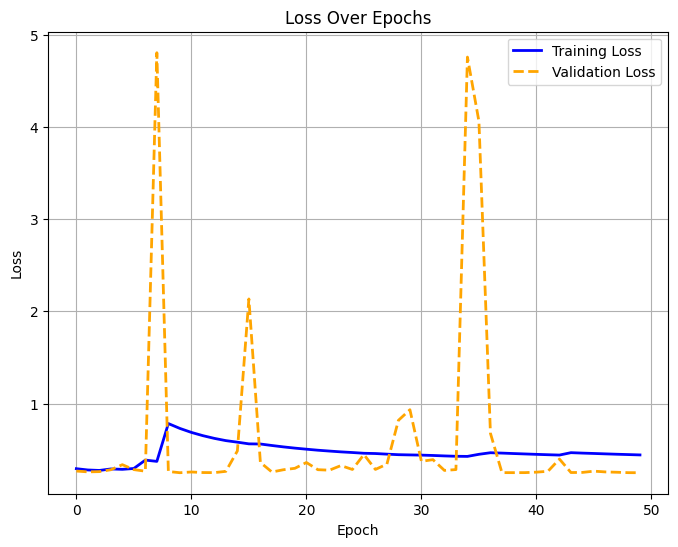

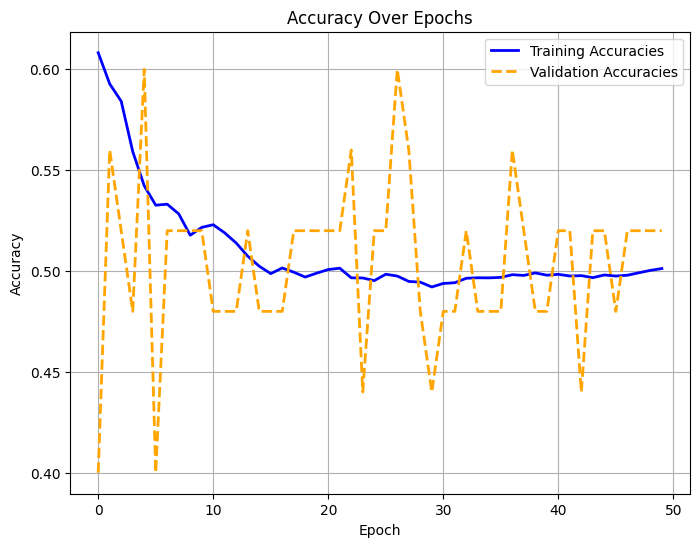

In [55]:
sets = {
    "X_train": X_train,
    "y_train": y_train,
    "X_val": X_val,
    "y_val": y_val,
    "X_test": X_test,
    "y_test": y_test
}

trainer = Trainer(sets)
train_losses, val_losses = trainer.run(best_hyperparams)

In [56]:
print(train_losses, val_losses) 

[np.float64(0.29349555425647605), np.float64(0.27952504074700035), np.float64(0.27442424248427355), np.float64(0.29052244374970787), np.float64(0.2863650479129966), np.float64(0.29568299685956034), np.float64(0.3866500805011277), np.float64(0.37272057591503044), np.float64(0.7829869376349905), np.float64(0.7303371475434927), np.float64(0.6870871052514969), np.float64(0.6517289603230098), np.float64(0.6221902870582859), np.float64(0.5978765588522028), np.float64(0.5810848518140267), np.float64(0.5627789003839233), np.float64(0.5611622435357156), np.float64(0.5450380302318867), np.float64(0.529936014331066), np.float64(0.5165446527206177), np.float64(0.5049407479783536), np.float64(0.4937921781465396), np.float64(0.4846060920481772), np.float64(0.4758441300369956), np.float64(0.4687607464340051), np.float64(0.46075728417988177), np.float64(0.4578489050590048), np.float64(0.451203263467243), np.float64(0.4453023861446372), np.float64(0.44286494963564893), np.float64(0.440639139872169), np

In [57]:
print(np.argmax(test_accuracies))
print(test_accuracies)
print(len(test_accuracies))
print(best_hyperparams)

ValueError: attempt to get argmax of an empty sequence

In [ ]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
# print(X_test.shape, y_test.shape)
# print(model.output, y_test)
loss_function.forward(model.output.squeeze(), y_test) 
# Calculate accuracy for the test set
predictions = np.round(model.output.squeeze())
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1) 
else:
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

(0.1, 1e-05, 0.0, 0.3, 16, 100, src.activation_functions.Activation_Leaky_ReLU) MONK2 Cross entropy ADAM

(0.1, 0.0, 0.0, 0.1, 16, 200, src.activation_functions.Activation_Tanh) MONK3 Cross entropy ADAM
test_result: 0.9144

MONK1:
    
    
MONK2:



MONK3:
Cross Entropy: 
(0.1, 0.0, 0.0, 0.1, 1, 100, src.activation_functions.Activation_Sigmoid) RMSprop
Test Accuracy: 0.9213
(0.1, 0.0, 0.0, 0.1, 1, 400, src.activation_functions.Activation_Sigmoid) Adam
Test Accuracy: 0.9606

MSE: 
{'learning_rate': 0.1, 'l1': 1e-05, 'l2': 0.0001, 'dropout_rate': 0.1, 'batch_size': 4, 'n_epochs': 50, 'activation': <class 'src.activation_functions.Activation_Tanh'>} 

In [ ]:
# n_epochs = 350
# batch_size = 1


# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # early_stopping = EarlyStopping(
# #     patience=20,
# #     min_delta_loss=0.0001,
# #     min_delta_accuracy=0.0001,
# #     restore_best_weights=True
# # )

# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []
    
#     # Mini-batch training
#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         dense1.forward(X_batch)
#         activation4.forward(dense1.output)
#         dense2.forward(activation4.output)
#         loss = loss_activation.forward(dense2.output, y_batch)
        
#         # Calculate accuracy for this batch
#         predictions = np.argmax(loss_activation.output, axis=1)
#         if len(y_batch.shape) == 2:
#             y_true = np.argmax(y_batch, axis=1)
#         else:
#             y_true = y_batch
#         accuracy = np.mean(predictions == y_true)
        
#         # Backward pass
#         loss_activation.backward(loss_activation.output, y_batch)
#         dense2.backward(loss_activation.dinputs)
#         activation4.backward(dense2.dinputs)
#         dense1.backward(activation4.dinputs)
        
#         # Update weights and biases
#         optimizer.pre_update_params()
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)
#         optimizer.post_update_params()
        
#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)
    
#     # Calculate epoch-level training metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_accuracy = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Validation pass (entire validation dataset)
#     dense1.forward(X_val)
#     activation4.forward(dense1.output)
#     dense2.forward(activation4.output)
#     val_loss = loss_activation.forward(dense2.output, y_val)
    
#     # Calculate validation accuracy
#     val_predictions = np.argmax(loss_activation.output, axis=1)
#     if len(y_val.shape) == 2:
#         y_val_true = np.argmax(y_val, axis=1)
#     else:
#         y_val_true = y_val
#     val_accuracy = np.mean(val_predictions == y_val_true)
    
#     # Append validation metrics
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
    
#     # early_stopping.on_epoch_end(
#     #     current_loss=val_loss,
#     #     current_accuracy=val_accuracy,
#     #     model=[dense1, dense2], 
#     #     epoch=epoch
#     # )
#     # if early_stopping.stop_training:
#     #     print(f"Early stopping at epoch {epoch}")
#     #     break
    
#     # Print progress
#     if not epoch % 100:
#         print(f"epoch: {epoch}, "
#               f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
#               f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
#               f"learning_rate: {optimizer.current_learning_rate}")

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")